In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [21]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../interpolated-data/positions_xyz_128px_full_new.csv')
dataCoordinates = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_full_new.csv')
dataPositions.shape, dataCoordinates.shape

((30067, 3), (30067, 14))

In [22]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values

combined = combined.dropna(thresh=combined.shape[1]-3)
combined

,32.611167757455355,80.1982370297045,45.03846153846154,83.3076923076923,86.92592592592592,39.333333333333336,0.3333333333333333,41.5,31.690857280117925,115.4632904327339,88.13636363636364,82.72727272727273,68.5,118.5,10.13833,3.169981,15.09998
0,32.611168,80.198237,43.350000,83.850000,87.000000,40.111111,0.444444,42.555556,31.690857,115.463290,89.500000,84.500000,68.500000,118.500000,10.133340,3.269852,15.19985
1,32.611168,80.198237,43.791667,84.666667,87.310345,41.034483,0.444444,43.444444,31.690857,115.463290,89.473684,85.631579,68.500000,118.500000,10.125010,3.369500,15.29950
2,32.611168,80.198237,43.411765,85.705882,87.400000,41.400000,0.666667,44.500000,31.690857,115.463290,89.777778,86.500000,68.500000,118.500000,10.113370,3.468816,15.39882
3,32.611168,80.198237,44.000000,86.285714,87.740741,42.000000,1.062500,45.437500,31.690857,115.463290,89.944444,87.222222,68.500000,118.500000,10.098430,3.567688,15.49769
4,32.611168,80.198237,44.166667,87.222222,87.750000,43.250000,1.400000,46.500000,31.690857,115.463290,90.470588,88.352941,68.500000,118.500000,10.080200,3.666008,15.59601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30062,122.000000,64.000000,79.000000,115.000000,121.000000,117.000000,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.720146,3.151380,7.95000
30063,123.000000,62.000000,96.000000,120.500000,121.000000,115.000000,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.714249,3.084737,7.95000
30064,123.000000,61.000000,96.000000,120.500000,121.000000,113.000000,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.708378,3.018077,7.95000
30065,123.000000,57.000000,79.000000,115.000000,121.000000,109.000000,45.465763,106.746940,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.702536,2.951475,7.95000


In [23]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

In [24]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
dfX = imputer.fit_transform(X)
y = imputer.fit_transform(y)

### Splitting the dataset into the Training set and Test set

In [25]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [26]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(18039, 6014, 6014)

### Hyperparameter tuning

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(100,), (150,), (200,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])
model = MLPRegressor(hidden_layer_sizes=(200, 150, 100), solver='sgd', max_iter=20000, early_stopping=True, random_state=42, activation='relu', learning_rate='adaptive', learning_rate_init=0.1)
# Perform a randomized search over the parameter grid
#random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [28]:
model.fit(X_train_scaled, y_train_scaled)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(200, 150, 100),
             learning_rate='adaptive', learning_rate_init=0.1, max_iter=20000,
             random_state=42, solver='sgd')

#### Result of the hyperparameter tuning

In [29]:
#model = random_search.best_estimator_

In [30]:
#print('fBest parameters found:\n', random_search.best_params_)

#### Make Predictions

In [31]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [32]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.5452374828228946
Mean Absolute Error on Validation Set: 0.3730575074847509
R2 Score on Validation set: 0.9780755866039977


In [33]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [34]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.5504296844115674
Mean Absolute Error on Test Set: 0.3719802881656613
R2 Score on Test set: 0.9778960143367548


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

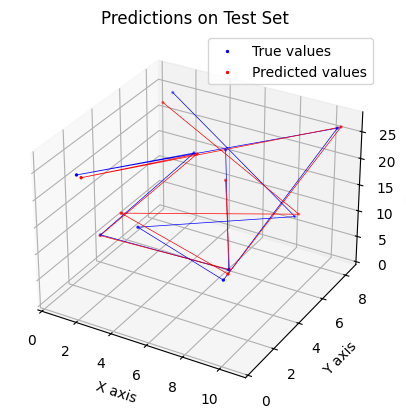

In [35]:
from utils.plot_maker import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [36]:
test_data = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_13h38m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',', decimal='.')

In [37]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna(thresh=new_combined.shape[1]-3)
new_combined = new_combined

In [38]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1474, 14), (1474, 3))

In [39]:
new_X_imputed = imputer.fit_transform(new_X)

new_X_scaled = scaler_X.fit_transform(new_X_imputed)
new_y_scaled = scaler_y.fit_transform(new_y)

In [40]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [41]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [42]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 4.8550553116850415
Mean Absolute Error on New Data Set: 1.5790493949179822
R2 Score on New Data set: 0.18338925601081793


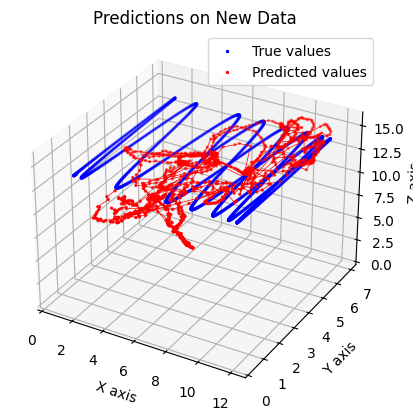

In [44]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")